In [1]:

# dataset from https://www.kaggle.com/datasets/kasikrit/att-database-of-faces?resource=download
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
from pathlib import Path
from keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
from keras import layers
#import keras one hot encoder
from keras.utils import to_categorical

directory="dataset"



def loadImages(folder, y):
    images = []
    labels = []
    pics = os.listdir(folder)
    for pic in pics:
        img = cv2.imread(os.path.join(folder,pic))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # transform to grayscale
        if img is not None:
            images.append(img)
            labels.append(y)
    return images, labels


def load_images_from_folder(folder):
    images = []
    labels = []
    dirs = os.listdir(folder)
    dirs.remove("README")
    for directory in dirs:
        y = directory[1:]
        path = os.path.join(folder, directory)
        i, l = loadImages(path, y)
        images = images + i 
        labels = labels + l
    images = np.array(images) 
    images = images.reshape(images.shape[0],images.shape[1] * images.shape[2])
    labels = np.array(labels)
    return images, labels

images, labels = load_images_from_folder(directory)
#reshape images
# images = images.reshape(images.shape[0], 112, 92, 1)
# images=np.expand_dims(images, axis=2)
images=images.astype('float32')
#normalize images
# images /= 255
labels=to_categorical(labels)
#shuffle data
indices = np.arange(images.shape[0])
np.random.shuffle(indices)
images = images[indices]/255.0
labels = labels[indices]


#split data
train_images = images[:int(images.shape[0]*0.8)]
train_labels = labels[:int(labels.shape[0]*0.8)]
test_images = images[int(images.shape[0]*0.8):]
test_labels = labels[int(labels.shape[0]*0.8):]



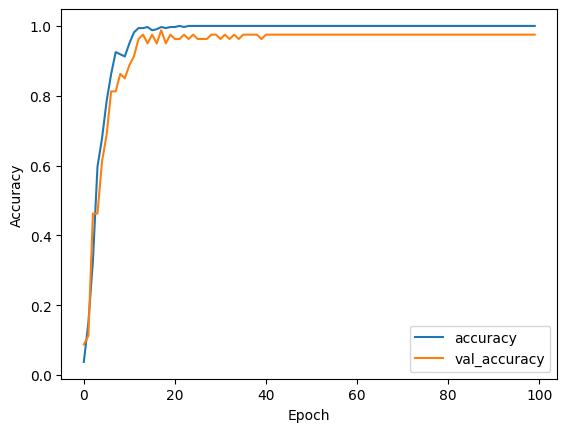

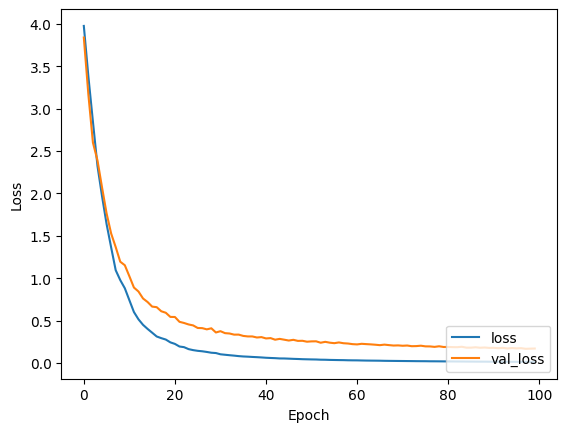

In [2]:
IMAGE_SIZE=224


model = tf.keras.Sequential([
        tf.keras.layers.Dense(10304*2, activation = 'tanh'),
        tf.keras.layers.Dense(labels.shape[1], 'softmax')
    ],
    name = 'MLP')


model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])


history=model.fit(
    train_images,train_labels,
        epochs=100,
        batch_size=8*4,
        validation_data=(test_images, test_labels),
        verbose=0
        )
plt.figure()
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')


plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim([0, 1])
plt.legend(loc='lower right')


GAN Consideration

In [ ]:
from tensorflow.keras.models import Model


input_shape=labels.shape[1]
# define generator
generator=tf.keras.models.Sequential([
    layers.Input(shape=input_shape),
    layers.Dense(7*7*256, use_bias=False),
    layers.Dense(train_images.shape[1], 'sigmoid')
])


# define discriminator
discriminator=tf.keras.models.Sequential([
    layers.Input(shape=train_images.shape[1]),
    layers.Dense(512, activation='relu'),
    layers.Dense(labels.shape[1], 'softmax')
])


#define GAN (I mean it looks like a distructured Autoencoder)
gan=Model(generator.input, discriminator(generator.output))


gan.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(1e-4))



Strategy-1: Input-->Predicted Labels, Output---> Predicted Labels

10/10 [==============================] - 0s 3ms/step


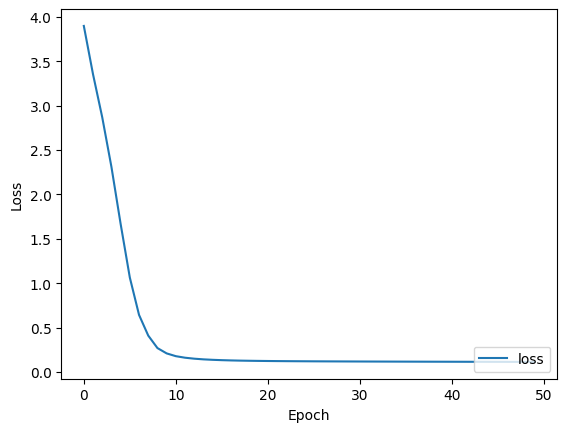

In [ ]:
train_predicted_labales=model.predict(train_images)

history=gan.fit(train_predicted_labales,train_predicted_labales,batch_size=16,verbose=0,epochs=50)


plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim([0, 1])
plt.legend(loc='lower right')


3/3 [==============================] - 0s 1ms/step


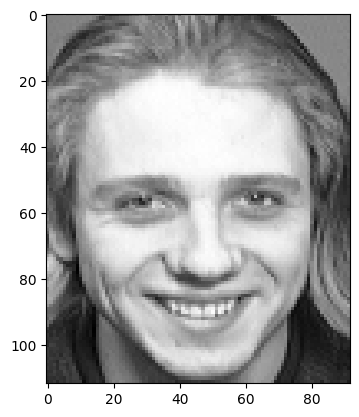

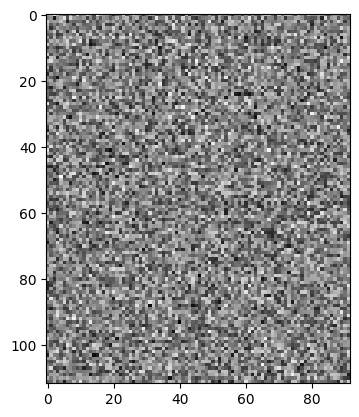

In [ ]:
ref_label=test_labels[0:1]
ref_image=test_images[0:1]
predicted_image=generator.predict(test_labels)*255.0

reference_image=ref_image.reshape(ref_image.shape[0], 112, 92, 1)
predicted_image=predicted_image.reshape(predicted_image.shape[0], 112, 92, 1)

plt.figure()
plt.imshow(reference_image[0,:,:,0], cmap='gray')

plt.figure()
plt.imshow(predicted_image[0,:,:,0], cmap='gray')



Strategy-2: Input-->Predicted Labels, Output---> Hard Labels

10/10 [==============================] - 0s 3ms/step


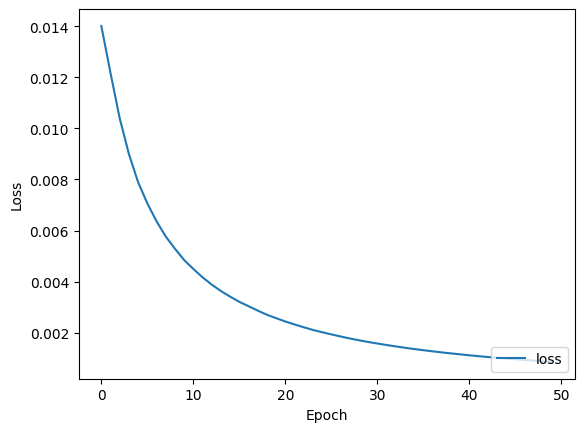

In [ ]:
train_predicted_labales=model.predict(train_images)

history=gan.fit(train_predicted_labales,train_labels,batch_size=16,verbose=0,epochs=50)


plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim([0, 1])
plt.legend(loc='lower right')


3/3 [==============================] - 0s 2ms/step


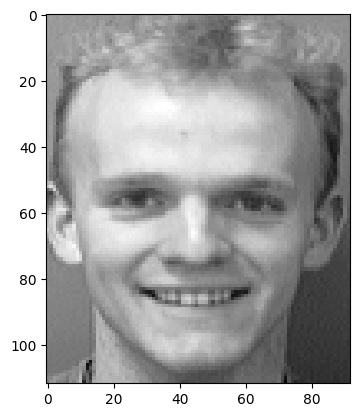

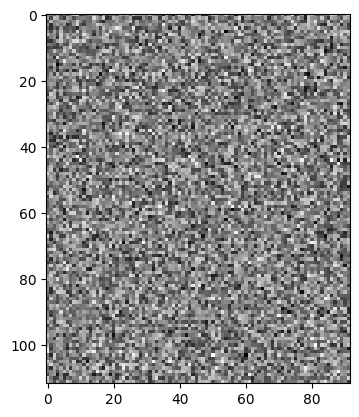

In [ ]:
ref_label=test_labels[0:1]
ref_image=test_images[0:1]
predicted_image=generator.predict(test_labels)*255.0

reference_image=ref_image.reshape(ref_image.shape[0], 112, 92, 1)
predicted_image=predicted_image.reshape(predicted_image.shape[0], 112, 92, 1)

plt.figure()
plt.imshow(reference_image[0,:,:,0], cmap='gray')

plt.figure()
plt.imshow(predicted_image[0,:,:,0], cmap='gray')


Strategy-3: Input--->Predicted Labels, Output--> Hard Labels, Discrminator--> Target Model (trainable=true)-------------------(White Box Attack)

In [4]:
from tensorflow.keras.models import Model
train_predicted_labales=model.predict(train_images)
input_shape=labels.shape[1]
# define generator
generator=tf.keras.models.Sequential([
    layers.Input(shape=input_shape),
    # layers.Dense(250, activation='tanh'),
    # layers.Dense(500, activation='tanh'),
    layers.Reshape((input_shape,1)),
    layers.Conv1DTranspose(
            filters=4, kernel_size=3, padding="same", strides=2, activation="relu"
        ),
    # layers.Conv1DTranspose(
    #         filters=64, kernel_size=7, padding="same", strides=2, activation="relu"
    #     ),
    # layers.Dropout(rate=0.1),
    # layers.Conv1DTranspose(
    #         filters=16, kernel_size=3, padding="same", strides=2, activation="relu"
    #     ),
    layers.Flatten(),
    # layers.Dense(2500, activation='tanh'),
    layers.Dense(train_images.shape[1], 'sigmoid')
])




#use model as discriminator
model.trainable=True
# define discriminator
input_d = keras.Input(shape=train_images.shape[1])
output_d= model(input_d, training=True)
discriminator = Model(input_d, output_d, name="discriminator")


#define GAN (I mean it looks like a distructured Autoencoder)
gan=Model(generator.input, discriminator(generator.output))


gan.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(1e-6))


10/10 [==============================] - 0s 40ms/step


3/3 [==============================] - 0s 4ms/step


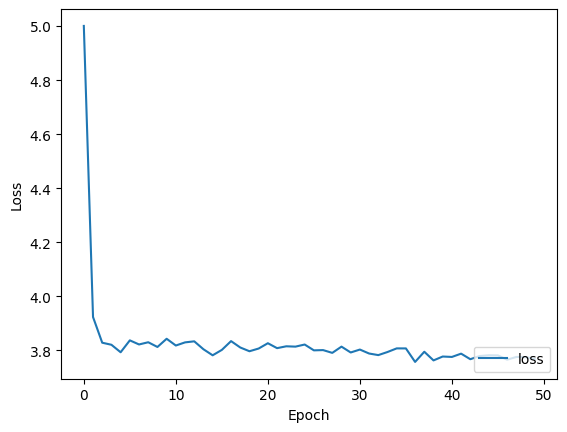

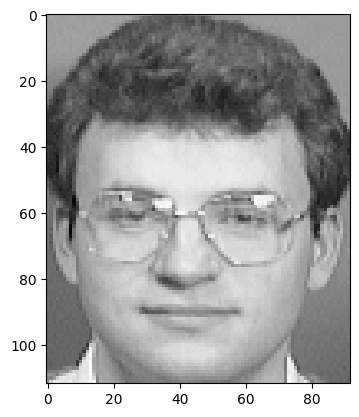

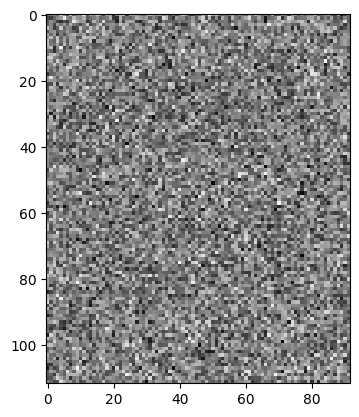

In [5]:
history=gan.fit(train_predicted_labales,train_labels,batch_size=4,verbose=0,epochs=50)


plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim([0, 1])
plt.legend(loc='lower right')



ref_label=test_labels[0:1]
ref_image=test_images[0:1]
predicted_image=generator.predict(test_labels)*255.0

reference_image=ref_image.reshape(ref_image.shape[0], 112, 92, 1)
predicted_image=predicted_image.reshape(predicted_image.shape[0], 112, 92, 1)

plt.figure()
plt.imshow(reference_image[0,:,:,0], cmap='gray')

plt.figure()
plt.imshow(predicted_image[0,:,:,0], cmap='gray')



Strategy-4: Input--->Predicted Labels, Output--> Hard Labels, Discrminator--> Target Model (trainable=False)-------------------(White Box Attack)

In [ ]:
from tensorflow.keras.models import Model

train_predicted_labales=model.predict(train_images)

input_shape=labels.shape[1]
# define generator
generator=tf.keras.models.Sequential([
    layers.Input(shape=input_shape),
    # layers.Dense(250, activation='tanh'),
    # layers.Dense(500, activation='tanh'),
    layers.Reshape((input_shape,1)),
    layers.Conv1DTranspose(
            filters=4, kernel_size=3, padding="same", strides=2, activation="relu"
        ),
    # layers.Conv1DTranspose(
    #         filters=64, kernel_size=7, padding="same", strides=2, activation="relu"
    #     ),
    layers.Dropout(rate=0.1),
    layers.Conv1DTranspose(
            filters=16, kernel_size=3, padding="same", strides=2, activation="relu"
        ),
    layers.Flatten(),
    # layers.Dense(2500, activation='tanh'),
    layers.Dense(train_images.shape[1], 'sigmoid')
])


#use model as discriminator
model.trainable=False


# define discriminator
input_d = keras.Input(shape=train_images.shape[1])
output_d= model(input_d)
discriminator = Model(input_d, output_d, name="discriminator")




#define GAN (I mean it looks like a distructured Autoencoder)
gan=Model(generator.input, discriminator(generator.output))


gan.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(1e-3))

3/3 [==============================] - 0s 3ms/step


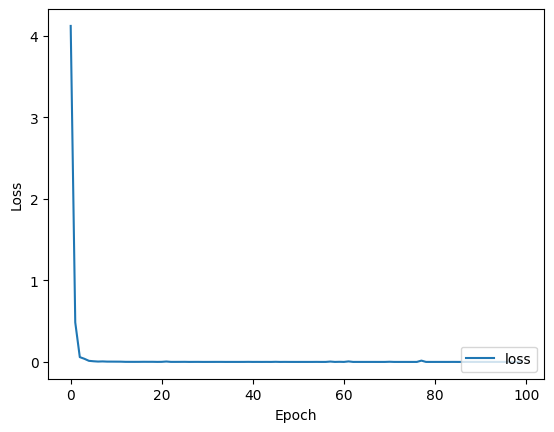

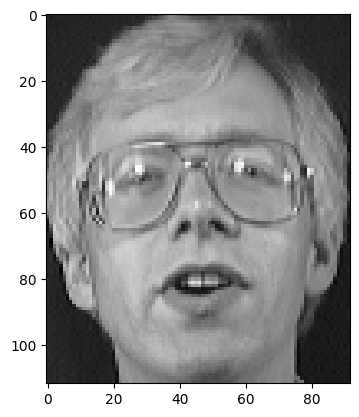

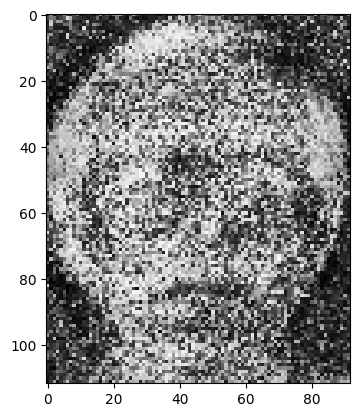

In [ ]:
history=gan.fit(train_predicted_labales,train_labels,batch_size=4,verbose=0,epochs=100)


plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim([0, 1])
plt.legend(loc='lower right')

ref_label=test_labels[0:1]
ref_image=test_images[0:1]
predicted_image=generator.predict(test_labels)*255.0

reference_image=ref_image.reshape(ref_image.shape[0], 112, 92, 1)
predicted_image=predicted_image.reshape(predicted_image.shape[0], 112, 92, 1)

plt.figure()
plt.imshow(reference_image[0,:,:,0], cmap='gray')

plt.figure()
plt.imshow(predicted_image[0,:,:,0], cmap='gray')
